## Setup && Installations

In [ ]:
import torch
from transformers import ViTForImageClassification
from transformers import AutoImageProcessor
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import numpy as np
from torchvision import models

import random

drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 256

Mounted at /content/drive


## Import && load the relevant models

In [ ]:
# VIT Model
VIT_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
CIFAR10_state_dict = torch.load("/content/drive/MyDrive/AdvMLPA1-01-VIT.pth", map_location=device)
VIT_model.load_state_dict(CIFAR10_state_dict, strict=False)

# VIT Preprocessor\
VIT_PreProcess = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-4-1a98a63a7175>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CIFAR10_state_dict = torch.load("/content/drive/MyDrive/AdvMLPA1-01-VIT.pth", map_location=de

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 97.3MB/s]
<ipython-input-2-7e7a1b515eba>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to constru

100%|██████████| 170498071/170498071 [00:12<00:00, 13376767.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
torch.Size([256, 3, 224, 224])


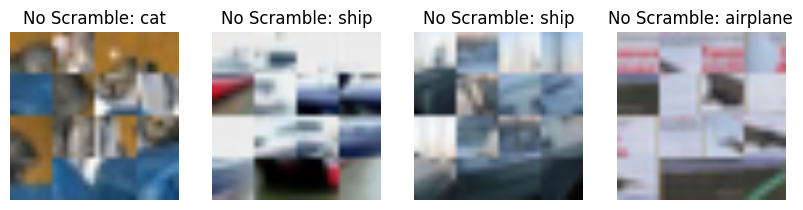

In [ ]:
# CNN Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = torch.nn.Linear(4096, 10)
vgg16.to(device)
vgg_state_dict = torch.load("/content/drive/MyDrive/vgg16_t2_cifar10.pth", map_location=device)
vgg16.load_state_dict(vgg_state_dict, strict=False)



# CNN Dataset Preperation
class ScramblerTransform:
    def __init__(self, scramble_order):
        # scramble_order should be a list of indices (length 16) defining the scramble order
        self.scramble_order = scramble_order

    def __call__(self, img):
        # Ensure img is a PIL Image, then convert to NumPy array
        x = np.array(img)
        if x.shape[-1] == 4:
            x = x[:, :, :3]  # Discard the alpha channel

        # Ensure the image is of size (32, 32)
        x = x[:32, :32]

        if len(x.shape) == 2:
            x = x[np.newaxis, :, :]  # Grayscale image, add dummy channel
        elif len(x.shape) == 3:
            x = x.transpose(2, 0, 1)  # Convert to (C, H, W) format
        else:
            raise ValueError("Unsupported image shape")

        C, H, W = x.shape

        # Step 1: Divide the tensor into 8x8 patches
        x_patches = x.reshape(C, H // 8, 8, W // 8, 8)
        x_patches = x_patches.transpose(1, 3, 0, 2, 4).reshape(-1, C, 8, 8)

        # Step 2: Scramble the patches
        x_patches_scrambled = x_patches[self.scramble_order]

        # Step 3: Reconstruct the scrambled tensor
        x_patches_scrambled = x_patches_scrambled.reshape(4, 4, C, 8, 8)
        x_patches_scrambled = x_patches_scrambled.transpose(2, 0, 3, 1, 4)
        x_scrambled = x_patches_scrambled.reshape(C, H, W)

        # Convert back to HWC format
        x_scrambled = x_scrambled.transpose(1, 2, 0)

        # Convert the NumPy array back to a PIL image
        img_scrambled = Image.fromarray(x_scrambled.astype(np.uint8))

        return img_scrambled

no_scramble_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
medium_scramble_order = [8, 1, 12, 3, 4, 5, 6, 7, 0, 9, 10, 11, 2, 14, 13, 15]
high_scramble_order = [2, 5, 1, 0, 14, 7, 9, 8, 3, 6, 4, 10, 11, 12, 13, 15]


# Transformations
transform0 = transforms.Compose([
    ScramblerTransform(no_scramble_order),
    transforms.Resize(224),
    transforms.ToTensor(),
])

transform1 = transforms.Compose([
    ScramblerTransform(medium_scramble_order),
    transforms.Resize(224),
    transforms.ToTensor(),
])

transform2 = transforms.Compose([
    ScramblerTransform(high_scramble_order),
    transforms.Resize(224),
    transforms.ToTensor(),
])

# Loading the Data
scr0_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform0)
scr1_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform1)
scr2_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2)
scr0_loader = DataLoader(scr0_dataset, batch_size=256, shuffle=False)
scr1_loader = DataLoader(scr1_dataset, batch_size=256, shuffle=False)
scr2_loader = DataLoader(scr2_dataset, batch_size=256, shuffle=False)

classes = scr0_dataset.classes

print(next(iter(scr2_loader))[0].shape)

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes = axes.ravel()

images, labels = next(iter(scr2_loader))

for i in range(4):
    image = images[i] # Select one image from a batch
    label = labels[i]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i].imshow(image)
    axes[i].set_title(f'No Scramble: {classes[label]}')
    axes[i].axis('off')  # Hide axis


In [ ]:
# Clip Model

## Dataset Preperation

We will create 3 dataloaders with the following properties: No Scramble, Medium Scramble, High Scramble. These will be called scr0_loader, scr1_loader, and scr2_loader. Medium Scramble will only move a few patches and mimic a real life distortion in the global structure. High Scramble will altogether alter the global structure and force the model to rely solely on localized features.

In [ ]:
def scrambler(img, scramble_order):
    # img is a PIL Image of size (32, 32)

    # Convert the PIL image to a NumPy array
    x = np.array(img)
    # If the image has an alpha channel, remove it
    if x.shape[-1] == 4:
        x = x[:, :, :3]  # Discard the alpha channel

    # Ensure the image is of size (32, 32)
    x = x[:32, :32]

    # Check if the image is grayscale or RGB
    if len(x.shape) == 2:
        # Grayscale image, add a dummy channel dimension
        x = x[np.newaxis, :, :]
    elif len(x.shape) == 3:
        # Transpose to get shape (C, H, W)
        x = x.transpose(2, 0, 1)
    else:
        raise ValueError("Unsupported image shape")

    C, H, W = x.shape

    # Step 1: Divide the tensor into 8x8 patches
    x_patches = x.reshape(C, H // 8, 8, W // 8, 8)
    x_patches = x_patches.transpose(1, 3, 0, 2, 4).reshape(-1, C, 8, 8)

    # Step 2: Scramble the patches in a predefined order
    x_patches_scrambled = x_patches[scramble_order]

    # Step 3: Reconstruct the scrambled tensor
    x_patches_scrambled = x_patches_scrambled.reshape(4, 4, C, 8, 8)
    x_patches_scrambled = x_patches_scrambled.transpose(2, 0, 3, 1, 4)
    x_scrambled = x_patches_scrambled.reshape(C, H, W)

    # Convert back to HWC format
    x_scrambled = x_scrambled.transpose(1, 2, 0)

    # Convert the NumPy array back to a PIL image
    img_scrambled = Image.fromarray(x_scrambled.astype(np.uint8))

    return img_scrambled

# predefined permutations
no_scramble_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
medium_scramble_order = [8, 1, 12, 3, 4, 5, 6, 7, 0, 9, 10, 11, 2, 14, 13, 15]
high_scramble_order = [2, 5, 1, 0, 14, 7, 9, 8, 3, 6, 4, 10, 11, 12, 13, 15]


tensorify = transforms.ToTensor();
def collate_fn_2(batch):
    images, labels = zip(*batch)
    inputs = []
    for img in images:
      inputs.append(scrambler(img, high_scramble_order))
    # inputs = [tensorify(img) for img in inputs]
    # inputs = torch.stack(inputs)
    inputs = VIT_PreProcess(images=inputs, return_tensors='pt')
    labels = torch.tensor(labels)
    return inputs["pixel_values"], labels


def collate_fn_1(batch):
    images, labels = zip(*batch)
    inputs = []
    for img in images:
      inputs.append(scrambler(img, medium_scramble_order))
    # inputs = [tensorify(img) for img in inputs]
    # inputs = torch.stack(inputs)
    inputs = VIT_PreProcess(images=inputs, return_tensors='pt')
    labels = torch.tensor(labels)
    return inputs["pixel_values"], labels

def collate_fn_0(batch):
    images, labels = zip(*batch)
    inputs = []
    for img in images:
      inputs.append(scrambler(img, no_scramble_order))
    # inputs = [tensorify(img) for img in inputs]
    # inputs = torch.stack(inputs)
    inputs = VIT_PreProcess(images=inputs, return_tensors='pt')
    labels = torch.tensor(labels)
    return inputs["pixel_values"], labels


# Getting CIFAR 10 Dataset
test_dataset = CIFAR10(root='./data', train=False, download=True)

# Setting Up Data Loaders
scr0_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_0)
scr1_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_1)
scr2_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_2)


# Set Up Classes
classes = test_dataset.classes

# Print the testloader
print(len(scr0_loader))
print(next(iter(scr0_loader))[0].shape)

Files already downloaded and verified
40
torch.Size([256, 3, 224, 224])


## Visualizing Scrambled Data
Note that here I have not used the preprocessor to visualize, but later I used the preprocessor while creating the dataloader instead of manually converting them to tensors first.

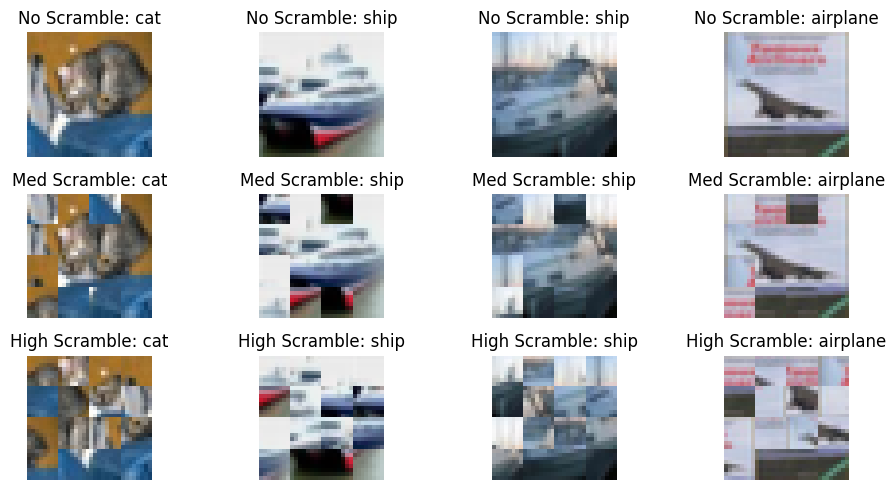

In [ ]:
# Set up the subplot grid
fig, axes = plt.subplots(3, 4, figsize=(10, 5))
axes = axes.ravel()

images, labels = next(iter(scr0_loader))

for i in range(4):
    image = images[i] # Select one image from a batch
    label = labels[i]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i].imshow(image)
    axes[i].set_title(f'No Scramble: {classes[label]}')
    axes[i].axis('off')  # Hide axis

images, labels = next(iter(scr1_loader))

for i in range(4):
    image = images[i] # Select one image from a batch
    label = labels[i]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i+4].imshow(image)
    axes[i+4].set_title(f'Med Scramble: {classes[label]}')
    axes[i+4].axis('off')  # Hide axis


images, labels = next(iter(scr2_loader))

for i in range(4):
    image = images[i] # Select one image from a batch
    label = labels[i]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i+8].imshow(image)
    axes[i+8].set_title(f'High Scramble: {classes[label]}')
    axes[i+8].axis('off')  # Hide axis


plt.tight_layout()
plt.show()


## Running Inference on Each Model for all 3 Types of Scrambling

First we will define a function to run inference as per our needs.

In [ ]:
def RunInference(model, loader):
  correct = 0
  total = 0
  model.to(device)
  with torch.no_grad():
    model.eval()
    for idx, (images, labels) in enumerate(loader):

      # print(images.shape)
      # inputs = preprocessor(images)
      # print(inputs.shape)
      inputs = images.to(device)
      labels = labels.to(device)

      outputs = VIT_model(pixel_values=inputs)
      # outputs = model(inputs)
      _, predicted = torch.max(outputs.logits.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      print(f"Batch {idx}: {correct}/{total} Correct")

  acc = 100 * correct / total
  return acc

def VITPreProcessor(input):
  val = VIT_PreProcess(images=input, return_tensors='pt')
  return val["pixel_values"]

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            print(f"{correct}/{total}")

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

Run Inference For ViT-B on All 3

In [ ]:
acc1 = RunInference(VIT_model, scr0_loader)
print(f"VIT Accuracy on 0 Scrambling: {acc1:.2f}%")

acc2 = RunInference(VIT_model, scr1_loader)
print(f"VIT Accuracy on Medium Scrambling: {acc2:.2f}%")

acc3 = RunInference(VIT_model, scr2_loader)
print(f"VIT Accuracy on High Scrambling: {acc3:.2f}%")

Batch 0: 245/256 Correct
Batch 1: 492/512 Correct
Batch 2: 741/768 Correct
Batch 3: 986/1024 Correct
Batch 4: 1231/1280 Correct
Batch 5: 1481/1536 Correct
Batch 6: 1731/1792 Correct
Batch 7: 1981/2048 Correct
Batch 8: 2224/2304 Correct
Batch 9: 2467/2560 Correct
Batch 10: 2714/2816 Correct
Batch 11: 2960/3072 Correct
Batch 12: 3203/3328 Correct
Batch 13: 3443/3584 Correct
Batch 14: 3687/3840 Correct
Batch 15: 3938/4096 Correct
Batch 16: 4186/4352 Correct
Batch 17: 4430/4608 Correct
Batch 18: 4677/4864 Correct
Batch 19: 4921/5120 Correct
Batch 20: 5169/5376 Correct
Batch 21: 5414/5632 Correct
Batch 22: 5659/5888 Correct
Batch 23: 5910/6144 Correct
Batch 24: 6160/6400 Correct
Batch 25: 6401/6656 Correct
Batch 26: 6649/6912 Correct
Batch 27: 6887/7168 Correct
Batch 28: 7136/7424 Correct
Batch 29: 7378/7680 Correct
Batch 30: 7624/7936 Correct
Batch 31: 7871/8192 Correct
Batch 32: 8110/8448 Correct
Batch 33: 8357/8704 Correct
Batch 34: 8603/8960 Correct
Batch 35: 8849/9216 Correct
Batch 36:

In [ ]:
acc1 = evaluate_model(vgg16, scr0_loader)
print(f"VGG Accuracy on 0 Scrambling: {acc1:.2f}%")

acc2 = evaluate_model(vgg16, scr1_loader)
print(f"VGG Accuracy on Medium Scrambling: {acc2:.2f}%")

acc3 = evaluate_model(vgg16, scr2_loader)
print(f"VGG Accuracy on High Scrambling: {acc3:.2f}%")

214/256
420/512
634/768
851/1024
1064/1280
1279/1536
1478/1792
1687/2048
1895/2304
2098/2560
2311/2816
2520/3072
2741/3328
2946/3584
3159/3840
3374/4096
3593/4352
3809/4608
4024/4864
4240/5120
4455/5376
4651/5632
4858/5888
5073/6144
5288/6400
5503/6656
5717/6912
5927/7168
6145/7424
6356/7680
6569/7936
6785/8192
6998/8448
7200/8704
7414/8960
7634/9216
7852/9472
8068/9728
8273/9984
8285/10000
Test Accuracy: 82.85%
VGG Accuracy on 0 Scrambling: 82.85%
155/256
319/512
459/768
616/1024
760/1280
916/1536
1064/1792
1211/2048
1370/2304
1515/2560
1668/2816
1820/3072
1979/3328
2127/3584
2276/3840
2437/4096
2606/4352
2764/4608
2929/4864
3071/5120
3224/5376
3374/5632
3520/5888
3683/6144
3826/6400
3960/6656
4110/6912
4258/7168
4422/7424
4569/7680
4724/7936
4883/8192
5045/8448
5198/8704
5351/8960
5511/9216
5660/9472
5825/9728
5970/9984
5980/10000
Test Accuracy: 59.80%
VGG Accuracy on Medium Scrambling: 59.80%
74/256
153/512
218/768
295/1024
361/1280
438/1536
511/1792
590/2048
665/2304
730/2560
808/2